# Explore Exercises
These exercises should go in a notebook or script named explore.

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

1. How many different cases are there, by department?

In [2]:
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



2. Does the percentage of cases that are late vary by department?

In [3]:
# add column "is_late" that is booleen then pivot on that with department? or to pandas?


3. On average, how late are the late cases by department?

In [4]:
(
    df.groupby('department')
    .pivot('case_late')
    .agg(mean('num_days_late'), count('num_days_late').alias('n_cases_late'))
    .show(truncate=False)
)

+------------------------+------------------------+------------------+-----------------------+-----------------+
|department              |false_avg(num_days_late)|false_n_cases_late|true_avg(num_days_late)|true_n_cases_late|
+------------------------+------------------------+------------------+-----------------------+-----------------+
|Solid Waste             |-3.4484943282002587     |246325            |7.186821906120899      |32945            |
|Animal Care Services    |-288.2149778603364      |93639             |23.458633245820124     |23276            |
|Trans & Cap Improvements|-22.36425447007597      |90782             |10.603064680316946     |5411             |
|Customer Service        |-8.053626989275326      |839               |87.68385942150394      |2010             |
|Parks & Recreation      |-11.796051012138909     |16110             |22.348910457867518     |3797             |
|Metro Health            |-7.093983767419706      |4334              |6.5438133155476494     |82

4. What is the service type that is the most late? Just for Parks & Rec?

In [5]:
(
    df.filter('case_late')
    .groupby('department', 'service_request_type')
    .agg(mean('num_days_late'), count('num_days_late').alias('n_cases_late'))
    .sort(col('avg(num_days_late)').desc())    
    .show(truncate=False)
)

+------------------------+----------------------------------------+------------------+------------+
|department              |service_request_type                    |avg(num_days_late)|n_cases_late|
+------------------------+----------------------------------------+------------------+------------+
|DSD/Code Enforcement    |Zoning: Recycle Yard                    |210.89201994318182|132         |
|DSD/Code Enforcement    |Zoning: Junk Yards                      |200.20517608494276|262         |
|DSD/Code Enforcement    |Structure/Housing Maintenance           |190.20707698509807|51          |
|DSD/Code Enforcement    |Donation Container Enforcement          |171.09115313942615|122         |
|DSD/Code Enforcement    |Storage of Used Mattress                |163.96812829714287|7           |
|DSD/Code Enforcement    |Labeling for Used Mattress              |162.43032902285717|7           |
|DSD/Code Enforcement    |Record Keeping of Used Mattresses       |153.99724039428568|7           |


In [6]:
# just for Parks & Rec
(
    df.filter('case_late')
    .filter(col("department") == "Parks & Recreation")
    .groupby('service_request_type')
    .agg(mean('num_days_late'), count('num_days_late').alias('n_cases_late'))
    .sort(col('avg(num_days_late)').desc())    
    .show(truncate=False)
)

+-------------------------------------+------------------+------------+
|service_request_type                 |avg(num_days_late)|n_cases_late|
+-------------------------------------+------------------+------------+
|Amenity Park Improvement             |76.87018194568    |25          |
|Major Park Improvement Install       |75.79450367282354 |17          |
|Reservation Assistance               |66.03116319       |2           |
|Park Building Maint Invest           |59.367469802695666|23          |
|Sportfield Lighting                  |51.480049793645534|268         |
|Electrical                           |42.951971658345116|481         |
|Tree Removal                         |40.28404224560715 |84          |
|Landscape Maintenance                |38.86797941326316 |19          |
|Heavy Equipment                      |38.56625730831579 |19          |
|Miscellaneous Park Equipment         |33.62472491253488 |43          |
|Tree Trimming/Maintenance            |30.702768979017545|171   

5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [7]:
# DSD/Code Eforcement Dept
(
    df.filter(col("department") == "Solid Waste")
    .groupby('service_request_type')
    .agg(count('service_request_type').alias('n_cases'))
    .sort(col('n_cases').desc())    
    .show(truncate=False)
)

+----------------------------------------------+-------+
|service_request_type                          |n_cases|
+----------------------------------------------+-------+
|No Pickup                                     |86855  |
|Damaged Cart                                  |30338  |
|Cart Exchange Request                         |22024  |
|Lost/Stolen Cart                              |18731  |
|Dead Animal - Dog                             |16714  |
|Cart Delivery                                 |15471  |
|Dead Animal - Cat                             |14983  |
|Dead Animal - Misc                            |13234  |
|Cart PickUp                                   |10081  |
|1st Call Bagged Leaves                        |6554   |
|Solid Waste Fees and Charges                  |5104   |
|Brush - Out of Cycle Collection - Fee Required|4840   |
|Illegal Dumping (Non- residential areas)      |4670   |
|Disability Assistance Missed Pickup           |4019   |
|Additional Cart Request       

In [8]:
# Transportation and Capital Improvements Dept
(
    df.filter(col("department") == "Trans & Cap Improvements")
    .groupby('service_request_type')
    .agg(count('service_request_type').alias('n_cases'))
    .sort(col('n_cases').desc())    
    .show(truncate=False)
)

+------------------------------------------------+-------+
|service_request_type                            |n_cases|
+------------------------------------------------+-------+
|Pot Hole Repair                                 |20616  |
|Traffic Signal Ops and Maintenance - Emergency  |7997   |
|Traffic Sign Missing/Down                       |5674   |
|Base/Pavement Repair                            |5385   |
|Signal Timing Modification                      |4414   |
|Traffic Signal Ops and Maintenance              |4382   |
|Stop/Yield Sign Down/Missing/Faded              |3968   |
|Drainage Channel/Debris Removal                 |3105   |
|Initiating Unknown Project Investigation        |2859   |
|Curb or Sidewalk Investigation                  |2628   |
|Tree Fallen                                     |2388   |
|Traffic Sign Graffiti                           |2123   |
|Traffic Sign Faded                              |2122   |
|Street Sweeping                                 |1911  

In [9]:
# Metro Health Dept
(
    df.filter(col("department") == "Metro Health")
    .groupby('service_request_type')
    .agg(count('service_request_type').alias('n_cases'))
    .sort(col('n_cases').desc())    
    .show(truncate=False)
)

+-----------------------------+-------+
|service_request_type         |n_cases|
+-----------------------------+-------+
|License Renewal Invoice      |1349   |
|Hygienic Practices           |946    |
|Pests                        |715    |
|Food Contact Surfaces        |602    |
|Public Right of Way          |538    |
|Food Borne Illness           |259    |
|Food Poisoning               |256    |
|Working without a License    |165    |
|Public/Semi-Public Pools/Spas|165    |
|Sanitary Conditions          |107    |
|Food Source                  |24     |
|Smoking Ordinance            |22     |
|Ventilation                  |14     |
|Rescheduling Event           |1      |
+-----------------------------+-------+



6. Does whether or not its a weekend matter for when a case is opened/closed?

In [10]:
# first agg by day in Spark, drop minute and hour
cases_by_day = df.select(
    "department",
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
    date_format("case_closed_date", "yyyy-MM-dd").alias("case_closed_date"),
)

In [11]:
# based on the opened date column created above, group by the date and count the number of cases for that day
# send this to Pandas, convert each to Pandas datetime, set the date as index with the count
cases_opened_by_day = (
    cases_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cases_opened_by_day.name = 'cases_opened'
cases_opened_by_day

case_opened_date
2017-01-01     155
2017-01-02    1397
2017-01-03    1760
2017-01-04    1613
2017-01-05    1791
              ... 
2018-08-04     665
2018-08-05     319
2018-08-06    2071
2018-08-07    2405
2018-08-08     604
Name: cases_opened, Length: 585, dtype: int64

In [12]:
# do the above steps again for case closed date
cases_closed_by_day = (
    cases_by_day
    .groupby('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date=lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)
cases_closed_by_day.name = 'cases_closed'

In [13]:
# concat these series together
ts = pd.concat([cases_opened_by_day, cases_closed_by_day], axis=1)
ts
# now we have a time series Pandas df to visualize with

,cases_opened,cases_closed
2017-01-01,155,67
2017-01-02,1397,385
2017-01-03,1760,734
2017-01-04,1613,1206
2017-01-05,1791,1173
...,...,...
2018-08-04,665,730
2018-08-05,319,197
2018-08-06,2071,1713
2018-08-07,2405,2096


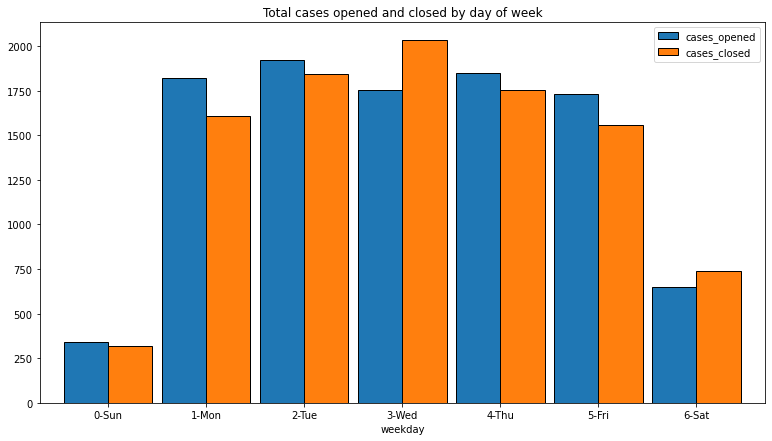

In [14]:
# create a weekday column that has the number of day and abreviation for day to use as lables
ts['weekday'] = ts.index.strftime('%w-%a')
# get the average cases open/closed by day as a bar chart
ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)

plt.title('Total cases opened and closed by day of week')
plt.xticks(rotation=0)
plt.show()

In [15]:
# fewer cases are opened and closed on the weekend on average
# generally more cases are opened per day than closed expect on Wed and Sat


7. On average, how many cases are opened a day for the Customer Service department?

In [16]:
# first filter then agg by day in Spark, drop minute and hour
cs_by_day = df.filter(col("department") == "Customer Service").select("department",    
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
)

In [17]:
cs_opened_by_day = (
    cs_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
cs_opened_by_day.name = 'cases_opened'
cs_opened_by_day

case_opened_date
2017-01-02     3
2017-01-03     6
2017-01-04     2
2017-01-05     5
2017-01-06     3
              ..
2018-08-02    13
2018-08-03     8
2018-08-04     2
2018-08-06     5
2018-08-07     9
Name: cases_opened, Length: 512, dtype: int64

In [20]:
cs_ts = pd.DataFrame(cs_opened_by_day)

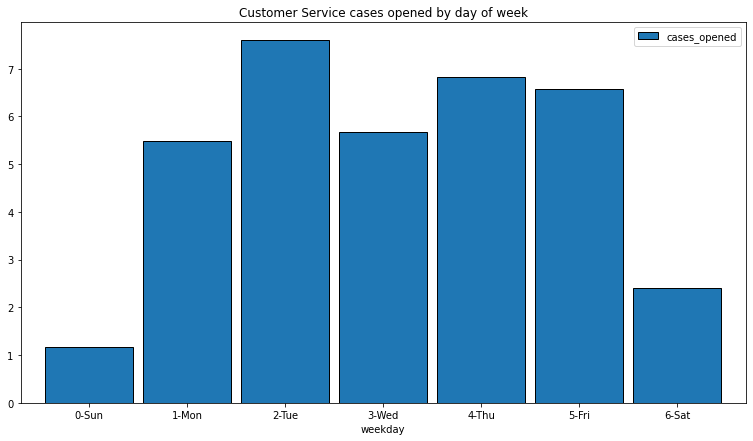

In [23]:
cs_ts['weekday'] = cs_ts.index.strftime('%w-%a')
# get the average cases open/closed by day as a bar chart
cs_ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.title('Customer Service cases opened by day of week')
plt.xticks(rotation=0)
plt.show()

8. Does the number of service requests for the solid waste department vary by day of the week?

In [25]:
# Service requests by Solid Waste dept
(
    df.filter(col("department") == "Solid Waste")
    .groupby('service_request_type')
    .agg(count('service_request_type').alias('n_cases'))
    .sort(col('n_cases').desc())    
    .show(truncate=False)
)

+-------+
|n_cases|
+-------+
|279270 |
+-------+



In [27]:
sw_by_day = df.filter(col("department") == "Solid Waste").select("department",    
    date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"),
)

In [28]:
sw_opened_by_day = (
    sw_by_day
    .groupby('case_opened_date')
    .count()
    .na.drop()
    .sort('case_opened_date')
    .toPandas()
    .assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')
    ['count']
)
sw_opened_by_day.name = 'cases_opened'
sw_opened_by_day

case_opened_date
2017-01-01     43
2017-01-02    722
2017-01-03    771
2017-01-04    545
2017-01-05    586
             ... 
2018-08-04    175
2018-08-05     90
2018-08-06    775
2018-08-07    714
2018-08-08    191
Name: cases_opened, Length: 585, dtype: int64

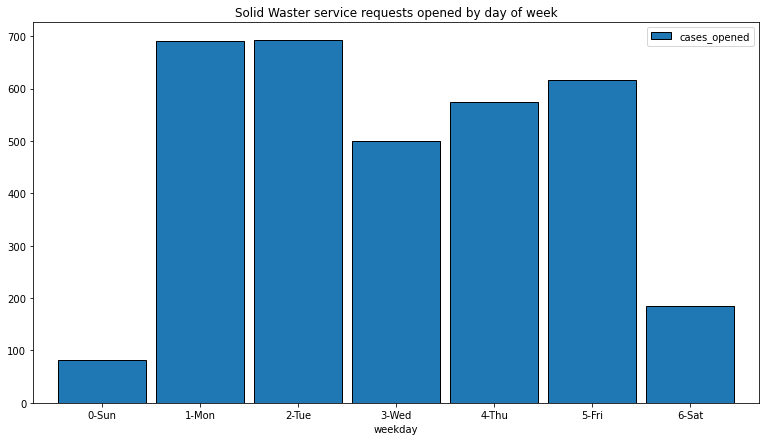

In [29]:
sw_ts = pd.DataFrame(sw_opened_by_day)
sw_ts['weekday'] = sw_ts.index.strftime('%w-%a')
# get the average cases open/closed by day as a bar chart
sw_ts.groupby('weekday').mean().plot.bar(figsize=(13, 7), ec='black', width=.9)
plt.title('Solid Waster service requests opened by day of week')
plt.xticks(rotation=0)
plt.show()